## Model training for only two classes.

## Model training for all the classes 

#### NOTE : This code shuffle the sample files after merging them from different class folders

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import joblib

In [2]:
# Step 1: Set Directories
bitumen_dir = 'bitumen_processed'    # Change this
concrete_dir = 'concrete_processed'  # Change this
block_dir = 'block_processed'        # Change this
kanker_dir = 'kanker_processed'      # Change this

In [3]:
# Step 2: Load all samples
def load_samples_from_folder(folder, label):
    samples = []
    for filename in os.listdir(folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(folder, filename)
            df = pd.read_csv(filepath)

            # Drop unnecessary columns
            df = df.drop(columns=['ID', 'SrNo', 'Timestamp'], errors='ignore')

            samples.append((df.values, label))  # (features, label)
    return samples

In [4]:
# Load all data
bitumen_samples = load_samples_from_folder(bitumen_dir, 0)  # 0 for bitumen
concrete_samples = load_samples_from_folder(concrete_dir, 1)  # 1 for concrete
block_samples = load_samples_from_folder(block_dir, 2)  # 2 for block
kanker_samples = load_samples_from_folder(kanker_dir, 3)  # 3 for kanker

all_samples = bitumen_samples + concrete_samples + block_samples + kanker_samples
np.random.shuffle(all_samples)

In [5]:
# Step 3: Separate X and y
X = np.array([sample[0] for sample in all_samples])  # shape (n_samples, 250, num_features)
y = np.array([sample[1] for sample in all_samples])  # shape (n_samples,)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Step 4: Normalize the features
# Reshape for normalization
n_samples, timesteps, n_features = X.shape
X_reshaped = X.reshape(-1, n_features)  # (n_samples * timesteps, n_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back
X = X_scaled.reshape(n_samples, timesteps, n_features)

X shape: (793, 250, 6)
y shape: (793,)


In [6]:
# Step 5: Encode labels for multiclass
y = to_categorical(y, num_classes=4)  # 4 classes now!

# Step 6: Train/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y.argmax(axis=1))
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1))

# Step 7: Build LSTM Model
model = Sequential([
    LSTM(64, input_shape=(timesteps, n_features), return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  # 4 outputs for 4 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250, 64)           18176     
                                                                 
 dropout (Dropout)           (None, 250, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 31,780
Trainable params: 31,780
Non-traina

In [21]:
# Step 8: Train the Model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


joblib.dump(scaler, 'scaler.save')  # Save after training
 # Load during inference


# Save the trained model
model.save('road_surface_classifier_multiclass.h5')
print("✅ Model saved as 'road_surface_classifier_multiclass.h5'!")



Epoch 1/50
18/18 [==============================] - 1s 40ms/step - loss: 0.3774 - accuracy: 0.8721 - val_loss: 0.5545 - val_accuracy: 0.7815
Epoch 2/50
18/18 [==============================] - 1s 32ms/step - loss: 0.3894 - accuracy: 0.8559 - val_loss: 0.3389 - val_accuracy: 0.8992
Epoch 3/50
18/18 [==============================] - 1s 30ms/step - loss: 0.3697 - accuracy: 0.8955 - val_loss: 0.7412 - val_accuracy: 0.7731
Epoch 4/50
18/18 [==============================] - 1s 29ms/step - loss: 0.4210 - accuracy: 0.8775 - val_loss: 0.3110 - val_accuracy: 0.9160
Epoch 5/50
18/18 [==============================] - 1s 28ms/step - loss: 0.9558 - accuracy: 0.7063 - val_loss: 1.4002 - val_accuracy: 0.5378
Epoch 6/50
18/18 [==============================] - 1s 30ms/step - loss: 0.9748 - accuracy: 0.6468 - val_loss: 1.1429 - val_accuracy: 0.5798
Epoch 7/50
18/18 [==============================] - 1s 29ms/step - loss: 0.8584 - accuracy: 0.6739 - val_loss: 1.0431 - val_accuracy: 0.6134
Epoch 8/50
18

4/4 [==============================] - 0s 33ms/step - loss: 0.3632 - accuracy: 0.9076
Test Accuracy: 0.9076


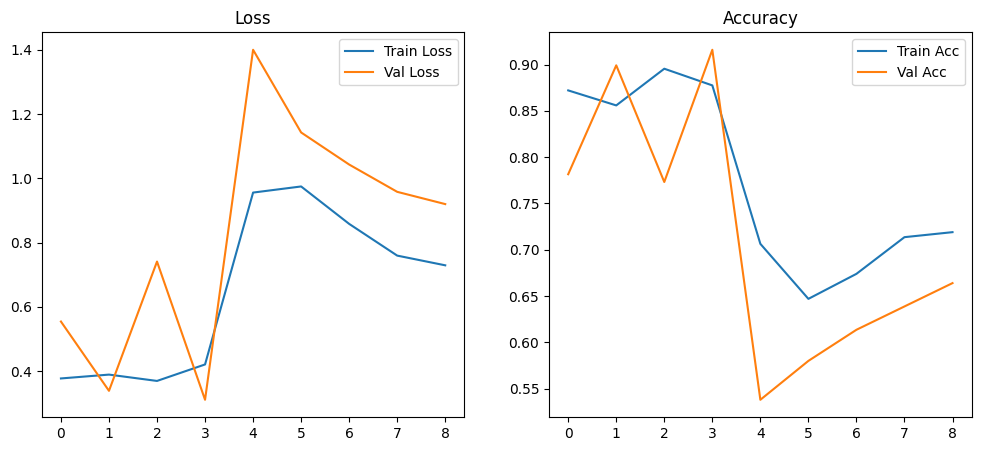

In [22]:
# Step 9: Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Step 10: Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.show()

In [23]:
# Step 11: Prediction & Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true_classes, y_pred_classes, target_names=['bitumen', 'concrete', 'block', 'kanker']))






4/4 [==============================] - 0s 30ms/step
              precision    recall  f1-score   support

     bitumen       0.85      0.93      0.89        30
    concrete       1.00      0.90      0.95        29
       block       0.93      0.93      0.93        30
      kanker       0.87      0.87      0.87        30

    accuracy                           0.91       119
   macro avg       0.91      0.91      0.91       119
weighted avg       0.91      0.91      0.91       119



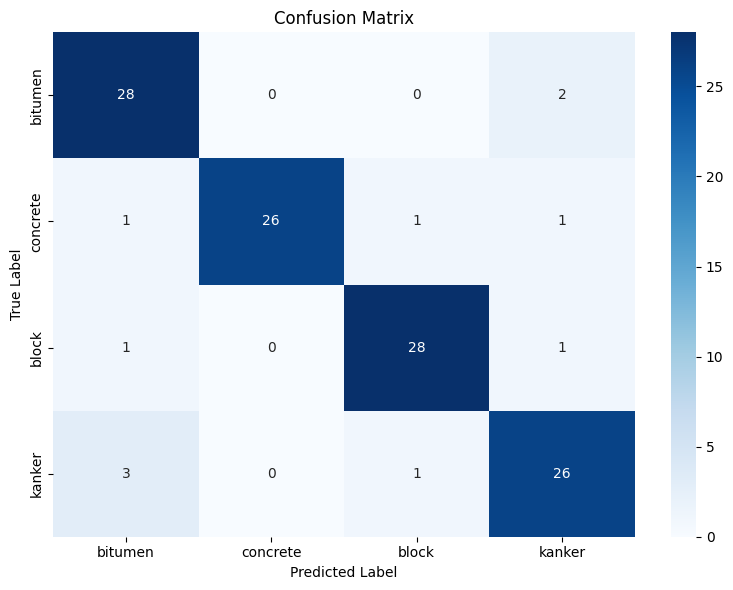

In [24]:

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
class_names = ['bitumen', 'concrete', 'block', 'kanker']

# Plot it using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Inferencing using the saved model



In [2]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
from tensorflow.keras.models import load_model



# Step 1: Load the trained model
model = load_model('road_surface_classifier_multiclass.h5')

# Step 2: Load the scaler
scaler = joblib.load('scaler.save')  # If you saved it earlier
# If you didn't save scaler earlier, comment this line and skip scaling (not ideal)

# Step 3: Define function to preprocess the input CSV
def preprocess_csv(filepath):
    df = pd.read_csv(filepath)

    # Drop unnecessary columns
    df = df.drop(columns=['ID', 'SrNo', 'Timestamp'], errors='ignore')

    # Check shape
    if df.shape[0] != 250:
        raise ValueError(f"Expected 250 rows for input, but got {df.shape[0]} rows!")

    X = df.values  # shape (250, num_features)
    # Scale the features
    X_scaled = scaler.transform(X)

    # Reshape for model input: (1, 250, num_features)
    X_scaled = np.expand_dims(X_scaled, axis=0)
    
    return X_scaled

# Step 4: Predict function
def predict_road_type(filepath):
    X_processed = preprocess_csv(filepath)
    preds = model.predict(X_processed)

    pred_class = np.argmax(preds, axis=1)[0]

    # Map prediction to label name
    class_labels = {
        0: "bitumen",
        1: "concrete",
        2: "block",
        3: "kanker"
    }

    predicted_label = class_labels[pred_class]
    confidence = preds[0][pred_class]

    return predicted_label, confidence

# Step 5: Example Usage
sample_csv_path = r'concrete_processed\034_HS_Concrete_20_12-2_part_005.csv'  # Change this

predicted_label, confidence = predict_road_type(sample_csv_path)

print(f"✅ Prediction: {predicted_label} (Confidence: {confidence*100:.2f}%)")


1/1 [==============================] - 1s 644ms/step
✅ Prediction: concrete (Confidence: 93.87%)
